In [ ]:
# # 날짜 간 차이 계산
# df['next_date'] = df['date'] + pd.Timedelta(days=1)
# df['date_diff'] = df['next_date'] - df['date']

# print(df)

# # 시간대 설정 및 변환
# df['date_utc'] = df['date'].dt.tz_localize('UTC')
# df['date_kst'] = df['date_utc'].dt.tz_convert('Asia/Seoul')


# # 범주형 피처 인코딩
# df = pd.get_dummies(df, columns=['destination'], drop_first=True)

# # 피처와 타겟 분리
# X = df.drop(columns=['price'])
# y = df['price']

# # 비행시간 피처 포함 모델
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# model = RandomForestRegressor(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# print("MSE with flight_duration:", mean_squared_error(y_test, y_pred))

# # 비행시간 피처 제거 모델
# X = X.drop(columns=['flight_duration'])
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# model = RandomForestRegressor(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# print("MSE without flight_duration:", mean_squared_error(y_test, y_pred))


In [3]:
!git clone --recursive https://github.com/microsoft/LightGBM
%cd LightGBM
!cmake -B build -S .
!cmake --build build -j4

fatal: destination path 'LightGBM' already exists and is not an empty directory.
/content/LightGBM/python-package/LightGBM
-- OpenCL include directory: /usr/include
-- Using _mm_prefetch
-- Using _mm_malloc
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /content/LightGBM/python-package/LightGBM/build
[  2%] Built target lightgbm_capi_objs
[ 89%] Built target lightgbm_objs
[ 92%] Built target _lightgbm
[100%] Built target lightgbm


In [55]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score

import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# 출발일로 부터 항공권 예매 시점(20240430)과의 날짜 차이 피처 추가 예정
now = pd.to_datetime("20240430", format='%Y%m%d')
print("Timestamp:", now)

Timestamp: 2024-04-30 00:00:00


In [107]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_csv('/content/drive/MyDrive/직항_머신러닝.csv')
except:
    df = pd.read_csv('./data/직항_머신러닝.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
df.describe(include='all')

,nights,departure_sdt,departure_jt,dep_week,arrival_sdt,arrival_jt,arr_week,agentcode,partition_0,partition_1,time_zone,baggagetype,total_fare
count,714792.000000,714792,714792.000000,714792.000000,714792,714792.000000,714792.000000,714792,714792,714792,714792,658137,7.147920e+05
unique,NaN,5558,NaN,NaN,6590,NaN,NaN,26,9,77,47,3,NaN
top,NaN,2024-05-03 08:45:00.000,NaN,NaN,2024-05-16 10:35:00.000,NaN,NaN,WHY002,SouthEastAsia,KIX,Asia/Tokyo,F,NaN
freq,NaN,646,NaN,NaN,579,NaN,NaN,191022,282421,88759,260126,612483,NaN
mean,3.517860,NaN,351.139806,3.956662,NaN,350.508071,4.024907,NaN,NaN,NaN,NaN,NaN,6.580351e+05
std,1.692131,NaN,265.785353,1.934085,NaN,272.773675,2.004756,NaN,NaN,NaN,NaN,NaN,6.435439e+05
min,1.000000,NaN,105.000000,1.000000,NaN,110.000000,1.000000,NaN,NaN,NaN,NaN,NaN,1.126000e+05
25%,2.000000,NaN,150.000000,2.000000,NaN,150.000000,2.000000,NaN,NaN,NaN,NaN,NaN,3.319000e+05
50%,4.000000,NaN,235.000000,4.000000,NaN,240.000000,4.000000,NaN,NaN,NaN,NaN,NaN,4.869000e+05
75%,5.000000,NaN,445.000000,6.000000,NaN,440.000000,6.000000,NaN,NaN,NaN,NaN,NaN,6.894000e+05


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714792 entries, 0 to 714791
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   nights         714792 non-null  int64 
 1   departure_sdt  714792 non-null  object
 2   departure_jt   714792 non-null  int64 
 3   dep_week       714792 non-null  int64 
 4   arrival_sdt    714792 non-null  object
 5   arrival_jt     714792 non-null  int64 
 6   arr_week       714792 non-null  int64 
 7   agentcode      714792 non-null  object
 8   partition_0    714792 non-null  object
 9   partition_1    714792 non-null  object
 10  time_zone      714792 non-null  object
 11  baggagetype    658137 non-null  object
 12  total_fare     714792 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 70.9+ MB


In [110]:
# jt 비행시간 350은 03시간50분으로 230분으로 변환
df['departure_jt'] = df['departure_jt'].apply(lambda x : str(x).zfill(4)).apply(lambda x : int(x[:2])*60+int(x[2:]))
df['arrival_jt'] = df['arrival_jt'].apply(lambda x : str(x).zfill(4)).apply(lambda x : int(x[:2])*60+int(x[2:]))

df[['departure_jt','arrival_jt']].head()

,departure_jt,arrival_jt
0,230,230
1,225,215
2,225,220
3,225,215
4,225,220


In [111]:
# str to datetime 형식 변환
df['departure_sdt'] = pd.to_datetime(df['departure_sdt'])
df['arrival_sdt'] = pd.to_datetime(df['arrival_sdt'])

# 시간 분 추출
df['departure_hour'] = df['departure_sdt'].apply(lambda x: x.hour)
df['departure_minute'] = df['departure_sdt'].apply(lambda x: x.minute)
df['arrival_hour'] = df['arrival_sdt'].apply(lambda x: x.hour)
df['arrival_minute'] = df['arrival_sdt'].apply(lambda x: x.minute)

# 출발 도착 시 분 sin cos 변환
df['departure_hour_sin'] = np.sin(2 * np.pi * df['departure_hour'] / 24)
df['departure_hour_cos'] = np.cos(2 * np.pi * df['departure_hour'] / 24)
df['departure_minute_sin'] = np.sin(2 * np.pi * df['departure_minute'] / 60)
df['departure_minute_cos'] = np.cos(2 * np.pi * df['departure_minute'] / 60)

df['arrival_hour_sin'] = np.sin(2 * np.pi * df['arrival_hour'] / 24)
df['arrival_hour_cos'] = np.cos(2 * np.pi * df['arrival_hour'] / 24)
df['arrival_minute_sin'] = np.sin(2 * np.pi * df['arrival_minute'] / 60)
df['arrival_minute_cos'] = np.cos(2 * np.pi * df['arrival_minute'] / 60)

# 출발 도착 요일 sin cos 변환
df['dep_week_sin'] = np.sin(2 * np.pi * df['dep_week'] / 7)
df['dep_week_cos'] = np.cos(2 * np.pi * df['dep_week'] / 7)
df['arr_week_sin'] = np.sin(2 * np.pi * df['arr_week'] / 7)
df['arr_week_cos'] = np.cos(2 * np.pi * df['arr_week'] / 7)


drop_col = ['departure_sdt','arrival_sdt',
            'departure_hour','departure_minute','arrival_hour','arrival_minute',
            'dep_week', 'arr_week']
df.drop(columns=drop_col,inplace=True)

In [112]:
# departure_jt, arrival_jt 출발 복귀 비행시간
# 직항 항공권 기준 목적지 피처와 다중공산성 문제가 있다고 예상 drop 전후로 모델 학습 후 판단.
# 경유 항공권 또는 비행기 도착시 현지시간으로 변환 할 때 사용

# drop_jt = ['departure_jt', 'arrival_jt']
# df.drop(columns=drop_jt,inplace=True)

In [113]:

# agentcode
# 대행사 별 주력 여행지가 있는지 시각화 필요
# 대항사와 여행지의 상관관계가 크다면 다중공산성 의심
# 대행사와 항공권 가격의 상관관계 확인 필요
df['agentcode'].value_counts()

agentcode
WHY002    191022
INT005    132661
TOV025    126221
HDP010     36763
CTR013     33286
WEB001     29843
HAT004     21279
LTT017     20460
ONT003     19443
EDR215     16647
NIT015     15247
MOT007     14674
VGT027     11854
KRT006      9921
SKP206      8107
MRT023      6115
HDT028      5456
JTB016      5019
GTG204      4243
ATK201      3226
ACA107      1431
BGT202      1068
YEL009       659
ACI117       140
ACX111         6
ALH103         1
Name: count, dtype: int64

In [114]:
# baggagetype
# "P" 수화물 포함
# [F, C] 수화물 미포함
df['baggagetype'].value_counts()

baggagetype
F    612483
P     42185
C      3469
Name: count, dtype: int64

In [115]:
# 'C', Nan 값을 F로 치환
df['baggagetype'] = df['baggagetype'].apply(lambda x: 'F' if x == 'C' else x).fillna('F')
df['baggagetype'].value_counts(normalize=True)

baggagetype
F    0.940983
P    0.059017
Name: proportion, dtype: float64

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714792 entries, 0 to 714791
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   nights                714792 non-null  int64  
 1   departure_jt          714792 non-null  int64  
 2   arrival_jt            714792 non-null  int64  
 3   agentcode             714792 non-null  object 
 4   partition_0           714792 non-null  object 
 5   partition_1           714792 non-null  object 
 6   time_zone             714792 non-null  object 
 7   baggagetype           714792 non-null  object 
 8   total_fare            714792 non-null  int64  
 9   departure_hour_sin    714792 non-null  float64
 10  departure_hour_cos    714792 non-null  float64
 11  departure_minute_sin  714792 non-null  float64
 12  departure_minute_cos  714792 non-null  float64
 13  arrival_hour_sin      714792 non-null  float64
 14  arrival_hour_cos      714792 non-null  float64
 15  

In [117]:
df

,nights,departure_jt,arrival_jt,agentcode,partition_0,partition_1,time_zone,baggagetype,total_fare,departure_hour_sin,...,departure_minute_sin,departure_minute_cos,arrival_hour_sin,arrival_hour_cos,arrival_minute_sin,arrival_minute_cos,dep_week_sin,dep_week_cos,arr_week_sin,arr_week_cos
0,2,230,230,WHY002,SouthEastAsia,HKG,Asia/Hong_Kong,F,249700,-5.000000e-01,...,-1.0,-1.836970e-16,0.866025,-0.500000,-0.500000,8.660254e-01,-0.781831,0.623490,0.781831,0.62349
1,2,225,215,TOV025,SouthEastAsia,HKG,Asia/Hong_Kong,F,279600,1.224647e-16,...,-1.0,-1.836970e-16,0.965926,-0.258819,1.000000,2.832769e-16,-0.781831,0.623490,0.781831,0.62349
2,2,225,220,TOV025,SouthEastAsia,HKG,Asia/Hong_Kong,F,279600,1.224647e-16,...,-1.0,-1.836970e-16,0.500000,-0.866025,-0.866025,-5.000000e-01,-0.781831,0.623490,0.781831,0.62349
3,2,225,215,TOV025,SouthEastAsia,HKG,Asia/Hong_Kong,F,279600,-5.000000e-01,...,-0.5,-8.660254e-01,0.965926,-0.258819,1.000000,2.832769e-16,-0.781831,0.623490,0.781831,0.62349
4,2,225,220,TOV025,SouthEastAsia,HKG,Asia/Hong_Kong,F,279600,-5.000000e-01,...,-0.5,-8.660254e-01,0.500000,-0.866025,-0.866025,-5.000000e-01,-0.781831,0.623490,0.781831,0.62349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714787,4,155,140,VGT027,Japan,TYO,Asia/Tokyo,F,373100,9.659258e-01,...,0.5,-8.660254e-01,-0.258819,-0.965926,0.500000,-8.660254e-01,0.974928,-0.222521,-0.781831,0.62349
714788,4,155,150,VGT027,Japan,TYO,Asia/Tokyo,F,373100,9.659258e-01,...,0.5,-8.660254e-01,-0.965926,-0.258819,0.866025,5.000000e-01,0.974928,-0.222521,-0.781831,0.62349
714789,4,155,160,VGT027,Japan,TYO,Asia/Tokyo,F,404200,9.659258e-01,...,0.5,-8.660254e-01,0.500000,-0.866025,0.866025,-5.000000e-01,0.974928,-0.222521,-0.781831,0.62349
714790,4,155,150,VGT027,Japan,TYO,Asia/Tokyo,F,382000,9.659258e-01,...,0.5,-8.660254e-01,0.258819,-0.965926,0.866025,5.000000e-01,0.974928,-0.222521,-0.781831,0.62349


In [118]:
def optimize_dataframe(df):
    """
    데이터프레임의 dtype을 최소화하여 메모리를 최적화하는 함수.

    Parameters:
    df (pd.DataFrame): 최적화할 데이터프레임

    Returns:
    pd.DataFrame: 최적화된 데이터프레임
    """
    # 정수형 컬럼 최적화
    int_columns = df.select_dtypes(include=['int64']).columns
    for col in int_columns:
        if df[col].min() >= np.iinfo(np.int8).min and df[col].max() <= np.iinfo(np.int8).max:
            df[col] = df[col].astype(np.int8)
        elif df[col].min() >= np.iinfo(np.int16).min and df[col].max() <= np.iinfo(np.int16).max:
            df[col] = df[col].astype(np.int16)
        elif df[col].min() >= np.iinfo(np.int32).min and df[col].max() <= np.iinfo(np.int32).max:
            df[col] = df[col].astype(np.int32)
        else:
            df[col] = df[col].astype(np.int64)

    # 부동소수점 컬럼 최적화
    float_columns = df.select_dtypes(include=['float64']).columns
    for col in float_columns:
        df[col] = df[col].astype(np.float32)

    # 객체형 컬럼 최적화
    object_columns = df.select_dtypes(include=['object']).columns
    for col in object_columns:
        num_unique_values = len(df[col].unique())
        num_total_values = len(df[col])
        if num_unique_values / num_total_values < 0.5:
            df[col] = df[col].astype('category')

    return df
df = optimize_dataframe(df)

In [119]:
# 메모리 최적화로 메모리 1/3으로 감소
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714792 entries, 0 to 714791
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   nights                714792 non-null  int8    
 1   departure_jt          714792 non-null  int16   
 2   arrival_jt            714792 non-null  int16   
 3   agentcode             714792 non-null  category
 4   partition_0           714792 non-null  category
 5   partition_1           714792 non-null  category
 6   time_zone             714792 non-null  category
 7   baggagetype           714792 non-null  category
 8   total_fare            714792 non-null  int32   
 9   departure_hour_sin    714792 non-null  float32 
 10  departure_hour_cos    714792 non-null  float32 
 11  departure_minute_sin  714792 non-null  float32 
 12  departure_minute_cos  714792 non-null  float32 
 13  arrival_hour_sin      714792 non-null  float32 
 14  arrival_hour_cos      714792 non-nul

In [120]:
# 사용하지 않을 컬럼 분리
# tz = df['time_zone']
# df = df.drop(columns=['time_zone'])

# 피처와 타겟 변수 분리
X = df.drop(columns=['total_fare'])
y = df['total_fare']


# 범주형 피처 식별
categorical_features = ['agentcode', 'partition_0', 'partition_1', 'time_zone', 'baggagetype']

# 라벨 인코딩 적용
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

In [68]:
# 학습 데이터, 검증 데이터, 테스트 데이터 분리
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# LightGBM 데이터셋 생성
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)


In [69]:
# import seaborn as sns

# plt.figure(figsize=(10, 8))
# sns.heatmap(df.select_dtypes(include=[int, float]).corr(), annot=True, cmap='coolwarm', linewidths=0.5)
# plt.title('Correlation Matrix')
# plt.show()

In [70]:
params = {
    'objective': 'regression',  # 회귀
    'metric': 'rmse',  # 평가 지표 (Root Mean Squared Error)
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'lambda_l2': 1.0,  # L2 정규화 (과적합 방지)
    'device': 'gpu'  # GPU 사용 설정
}

In [71]:
from tqdm import tqdm

# 학습 진행도를 출력하기 위해 콜백 함수 사용
tqdm_callback = lgb.callback.log_evaluation(period=50)
early_stopping_callback = lgb.early_stopping(stopping_rounds=50)

# LightGBM 모델 학습
model = lgb.train(params, train_data, valid_sets=[val_data], num_boost_round=10000, callbacks=[tqdm_callback, early_stopping_callback])

Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 233510
[100]	valid_0's rmse: 214993
[150]	valid_0's rmse: 205167
[200]	valid_0's rmse: 197087
[250]	valid_0's rmse: 191695
[300]	valid_0's rmse: 187828
[350]	valid_0's rmse: 184409
[400]	valid_0's rmse: 181111
[450]	valid_0's rmse: 179306
[500]	valid_0's rmse: 177364
[550]	valid_0's rmse: 175695
[600]	valid_0's rmse: 174267
[650]	valid_0's rmse: 173281
[700]	valid_0's rmse: 172147
[750]	valid_0's rmse: 171207
[800]	valid_0's rmse: 170511
[850]	valid_0's rmse: 169832
[900]	valid_0's rmse: 169349
[950]	valid_0's rmse: 169024
[1000]	valid_0's rmse: 168529
[1050]	valid_0's rmse: 167888
[1100]	valid_0's rmse: 167451
[1150]	valid_0's rmse: 167273
[1200]	valid_0's rmse: 167144
[1250]	valid_0's rmse: 166968
[1300]	valid_0's rmse: 166887
[1350]	valid_0's rmse: 166772
Early stopping, best iteration is:
[1327]	valid_0's rmse: 166727


In [72]:
# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# 모델 평가
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f'RMSE: {rmse:.4f}')

RMSE: 162534.2438


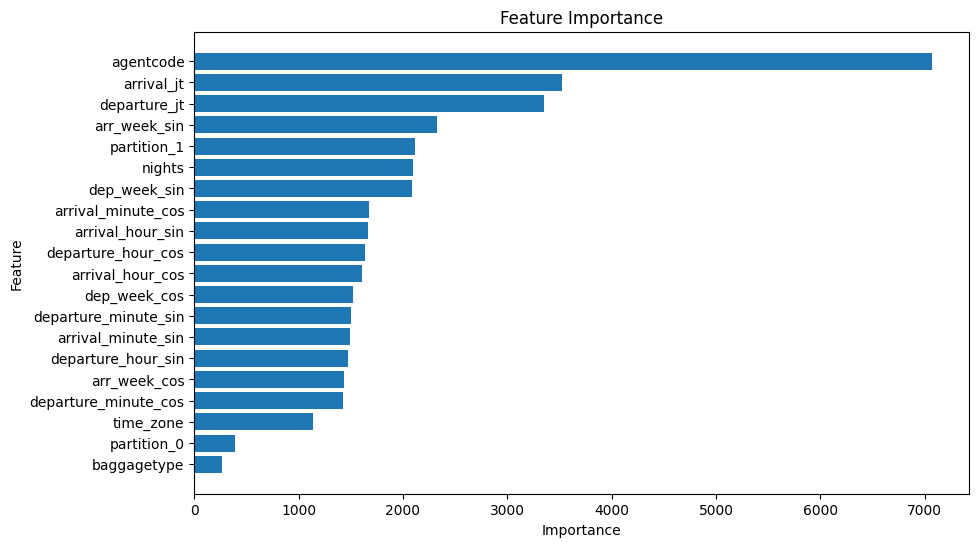

In [73]:
import matplotlib.pyplot as plt

# 피처 중요도 추출
importance = model.feature_importance(importance_type='split')
feature_names = model.feature_name()

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
})

# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='importance', ascending=False)

# 피처 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

                 Feature       VIF
0                 nights  3.788603
1             arrival_jt  2.957187
2              agentcode  5.005736
3     departure_hour_cos  1.426010
4   departure_minute_sin  1.014766
5   departure_minute_cos  1.008315
6       arrival_hour_sin  1.089887
7       arrival_hour_cos  1.239113
8     arrival_minute_sin  1.022606
9     arrival_minute_cos  1.001070
10          dep_week_sin  1.000160
11          dep_week_cos  1.045360
12          arr_week_cos  1.036959


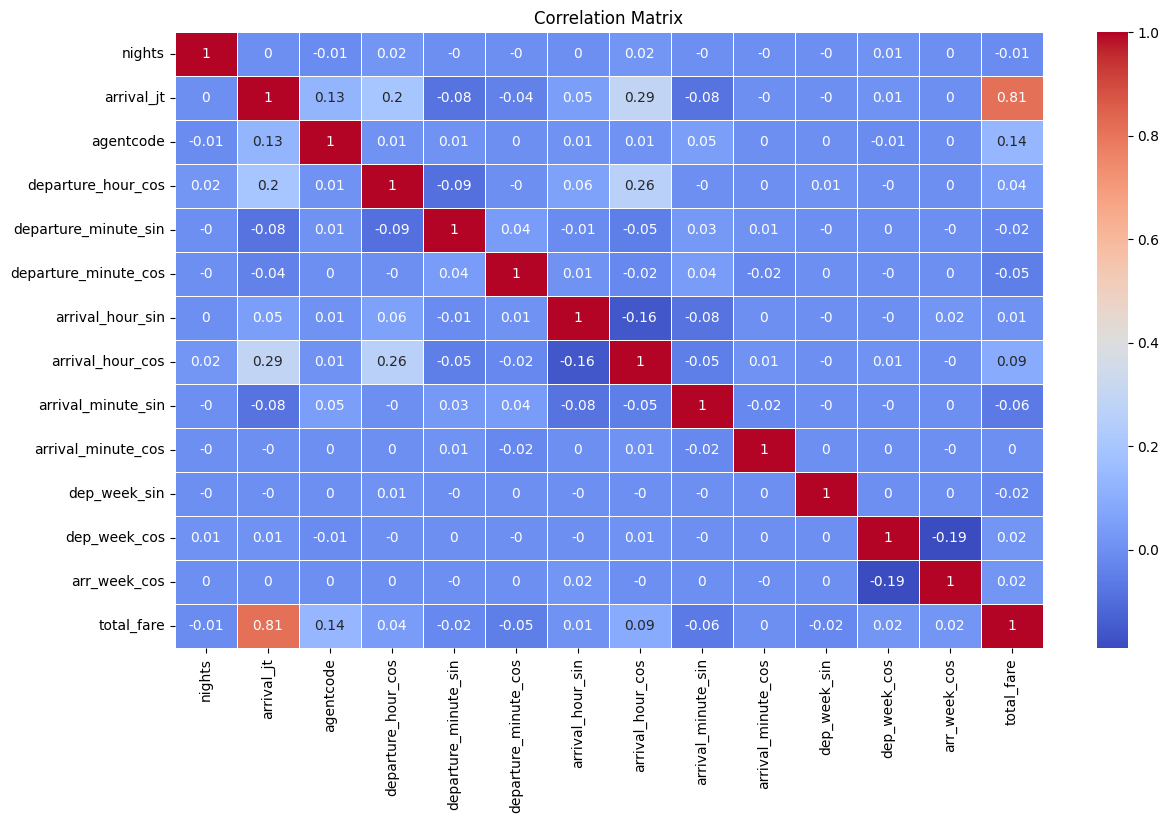

                            OLS Regression Results                            
Dep. Variable:             total_fare   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                 1.249e+05
Date:                Sun, 02 Jun 2024   Prob (F-statistic):               0.00
Time:                        08:56:07   Log-Likelihood:            -1.0151e+07
No. Observations:              714792   AIC:                         2.030e+07
Df Residuals:                  714778   BIC:                         2.030e+07
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1.978e+05 

In [130]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
def analyze_multicollinearity(X, y, figsize=(14, 8)):

    # 다중공산성 계산
    vif = pd.DataFrame()
    vif['Feature'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif)

    # 상관 행렬 계산 및 시각화
    corr_data = pd.concat([X, y], axis=1).corr().applymap(lambda x: round(x, 2))
    plt.figure(figsize=figsize)
    sns.heatmap(corr_data, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

    # 상수항 추가 (OLS 회귀를 위해)
    X = sm.add_constant(X)

    # OLS 회귀 모델 적합
    model = sm.OLS(y, X).fit()

    # 모델 요약 출력
    print(model.summary())


drop_col = ['partition_0', 'baggagetype', 'departure_jt', 'arr_week_sin','partition_1', 'time_zone',
            'departure_hour_sin']
droped_X = X.drop(columns = drop_col)

analyze_multicollinearity(droped_X,y)

In [127]:
# 학습 데이터, 검증 데이터, 테스트 데이터 분리
X_train, X_temp, y_train, y_temp = train_test_split(droped_X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# LightGBM 데이터셋 생성
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

model = lgb.train(params, train_data, valid_sets=[val_data], num_boost_round=10000, callbacks=[tqdm_callback, early_stopping_callback])

Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 240774
[100]	valid_0's rmse: 225498
[150]	valid_0's rmse: 213889
[200]	valid_0's rmse: 205067
[250]	valid_0's rmse: 199791
[300]	valid_0's rmse: 195475
[350]	valid_0's rmse: 192170
[400]	valid_0's rmse: 189576
[450]	valid_0's rmse: 187152
[500]	valid_0's rmse: 185260
[550]	valid_0's rmse: 183042
[600]	valid_0's rmse: 181676
[650]	valid_0's rmse: 180728
[700]	valid_0's rmse: 179430
[750]	valid_0's rmse: 178533
[800]	valid_0's rmse: 177333
[850]	valid_0's rmse: 176686
[900]	valid_0's rmse: 176176
[950]	valid_0's rmse: 175559
[1000]	valid_0's rmse: 174982
[1050]	valid_0's rmse: 174319
[1100]	valid_0's rmse: 173763
[1150]	valid_0's rmse: 173412
[1200]	valid_0's rmse: 173127
[1250]	valid_0's rmse: 172921
[1300]	valid_0's rmse: 172764
[1350]	valid_0's rmse: 172455
[1400]	valid_0's rmse: 172355
[1450]	valid_0's rmse: 172078
[1500]	valid_0's rmse: 171755
[1550]	valid_0's rmse: 171638
[1600]	valid_0's rmse: 171540

In [128]:
# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# 모델 평가
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f'RMSE: {rmse:.4f}')

RMSE: 165645.9025


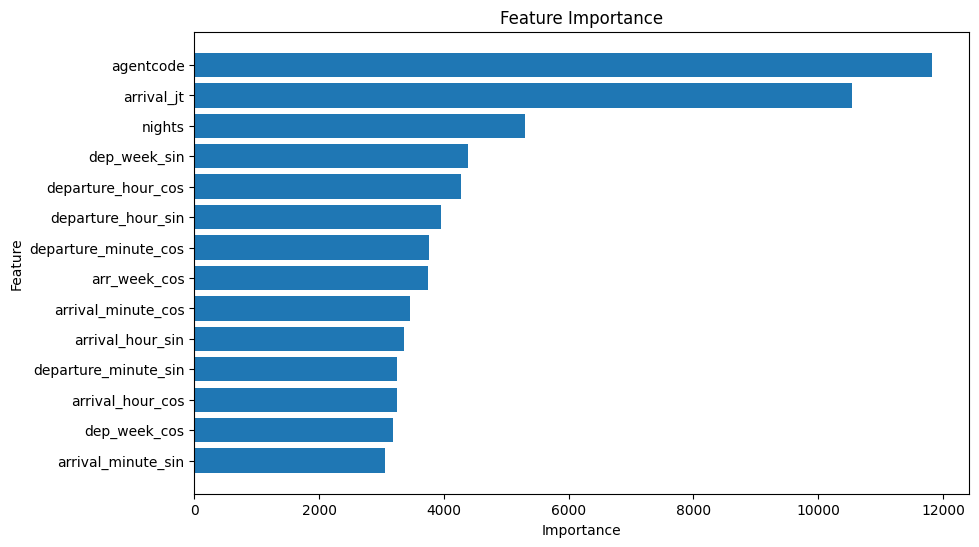

In [129]:
# 피처 중요도 추출
importance = model.feature_importance(importance_type='split')
feature_names = model.feature_name()

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
})

# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='importance', ascending=False)

# 피처 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()